In [66]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [68]:
# Transforms

train_transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
                       #T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.4),
                       T.RandomHorizontalFlip(p=0.5),
                       #T.RandomApply([T.RandomResizedCrop(size=32)], p=0.3)
])

validation_transform = T.Compose([
                      T.ToTensor(),
                      T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

test_transform = T.Compose([
                       T.ToTensor(),
                       T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [69]:
train_set = dset.CIFAR10('/content/drive/MyDrive/DataSets', train=True, transform=train_transform, download=True)
validation_set = dset.CIFAR10('/content/drive/MyDrive/DataSets', train=True, transform=validation_transform, download=True)
test_set = dset.CIFAR10('/content/drive/MyDrive/DataSets', train=False, transform=test_transform, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/DataSets/cifar-10-python.tar.gz to /content/drive/MyDrive/DataSets
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

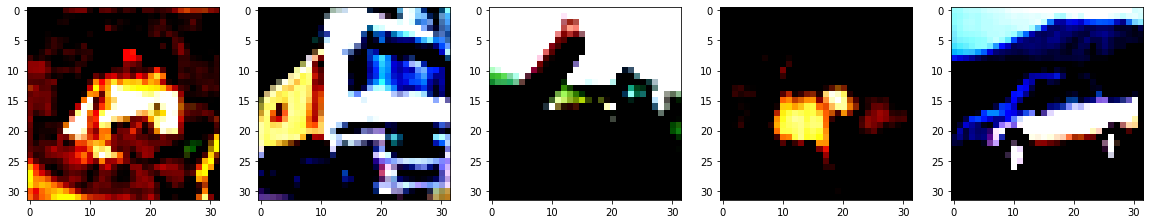

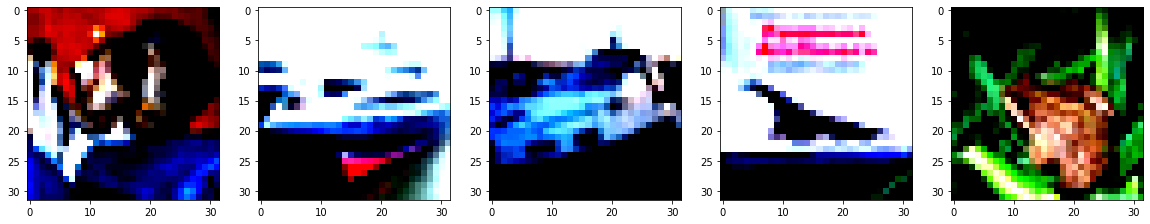

In [70]:
def print_some_images(dataset, start_num=0, num_img=5):

  """
  Print a few image from given dataset
  dataset - a dataset with tensors (images)
  start_num - an index of the image in the dataset from which the images are taken
  num_img - number of showing images (min = 1, max = 10)
  """

  import matplotlib.pyplot as plt

  if num_img < 1:
    num_img = 1
  elif num_img > 10:
    num_img = 10

  plt.figure(figsize=[20, 7])
  for i in range(num_img):
    plt.subplot(1, num_img, i + 1)
    img, _ = dataset.__getitem__(i + start_num)
    plt.imshow(img.permute(1, 2, 0))

print_some_images(train_set)
print_some_images(test_set)

In [71]:
NUM_TRAIN = 49000

train_loader = DataLoader(train_set, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
validation_loader = DataLoader(validation_set, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
test_loader = DataLoader(test_set, batch_size=64)

In [72]:
def flatten(X):
  """
  Flatten an image to vector
  """
  N = X.shape[0] # Num in batch
  return X.view(N, -1)

class Flatten(nn.Module):
  def forward(self, X):
    return flatten(X)

In [73]:
def train_model(model, optimizer, trainLoader, validationLoader, num_epoch=1, device=torch.device('cpu'), printAndSaveEvery=100, continueTraining=None):
  
  import torch.nn.functional as F

  if continueTraining is None:
    print("Starting new training")
    best_acc = 0
    train_accuracies = []
    val_accuracies = []
    start_ep = 0
  else:
    train_accuracies = continueTraining['train_accs']
    val_accuracies = continueTraining['val_accs']
    start_ep = continueTraining['num_ep']
    best_acc = val_accuracies[-1]
    print("Continue training from " + str(start_ep) + " epoch")

  model = model.to(device=device)

  for e in range(start_ep, num_epoch):
    print("Start " + str(e) + " epoch")
    for t, (x, y) in enumerate(trainLoader):

      model.train()
      x = x.to(device=device, dtype=torch.float32)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if t % printAndSaveEvery == 0 and t != 0:
        print("Iteration " + str(t) + ":")
        train_acc = check_accuracy(model, trainLoader, 'train', device)
        val_acc = check_accuracy(model, validationLoader, 'validation', device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if best_acc < val_acc:
          print("Goten new best val accuracy. Save new best model")
          best_acc = val_acc
          torch.save({
              'Model_state_dict': model.state_dict(),
              'Optimizer_state_dict': optimizer.state_dict(),
              'Num_epoch': e,
              'Train_accs': train_accuracies,
              'Val_accs': val_accuracies
          }, '/content/drive/MyDrive/best_model.pt')
          

    train_acc = check_accuracy(model, trainLoader, 'train', device)
    val_acc = check_accuracy(model, validationLoader, 'validation', device)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    torch.save({
        'Model_state_dict': model.state_dict(),
        'Optimizer_state_dict': optimizer.state_dict(),
        'Num_epoch': e + 1,
        'Train_accs': train_accuracies,
        'Val_accs': val_accuracies
    }, '/content/drive/MyDrive/model.pt')

  return(train_accuracies, val_accuracies)

In [74]:
def check_accuracy(model, dataLoader, typeOfCheck, device=torch.device('cpu')):
  """
  Checking accuracy on given dataSet in dataLoader
  typeOfCheck - train, validation or test
  """
  model = model.to(device=device)

  typeOfCheck = str.lower(typeOfCheck)

  model.eval()

  num_samples = 0
  num_correct = 0

  with torch.no_grad():
    for i, (x, y) in enumerate(dataLoader):
      x = x.to(device=device, dtype=torch.float32)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      _, preds = scores.max(1)

      num_samples += preds.shape[0]
      num_correct += (preds == y).sum()

      if typeOfCheck == 'train' and i == 100: # Чтобы проверяться не на всём огромном train сете (16 * 64 = 1024 как и у validation)
        break

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f) in %s'% (num_correct, num_samples, 100 * acc, typeOfCheck))
    return acc

In [75]:
def check_overfit_on_small_data(model, dataSet, optimizer, device=torch.device('cpu')):
  
  import torch.nn.functional as F

  loader = DataLoader(dataSet, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, 100)))

  model.to(device=device)
  for t, (x, y) in enumerate(loader):
    model.train()
    x = x.to(device=device, dtype=torch.float32)
    y = y.to(device=device, dtype=torch.long)

    scores = model(x)
    loss = F.cross_entropy(scores, y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    
    overfit_acc = check_accuracy(model, loader, 'overfit', device)
  
  overfit_acc = check_accuracy(model, loader, 'overfit', device)
  return(overfit_acc)

In [76]:
def createModel():
  model = None
  optimizer = None

  input_channels = 3
  channel_1 = 64
  channel_2 = 64
  channel_3 = 128
  channel_4 = 128
  dense_1 = 1024
  dense_2 = 512
  num_classes = 10

  learning_rate = 1e-4
  weight_decay = 1e-5

  model = nn.Sequential(
      nn.Conv2d(in_channels=input_channels, out_channels=channel_1, kernel_size=5, stride=1, padding=2), # 32 x 32 x 128
      nn.BatchNorm2d(num_features=channel_1),
      nn.ReLU(),
      nn.Conv2d(channel_1, channel_2, 5, 1, 2), # 32 x 32 x 64
      nn.BatchNorm2d(num_features=channel_2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # 16 x 16 x 64
      nn.Conv2d(channel_2, channel_3, kernel_size=3, stride=1, padding=1), # 16 x 16 x 128
      nn.BatchNorm2d(num_features=channel_3),
      nn.ReLU(),
      nn.Conv2d(channel_3, channel_4, kernel_size=3, stride=1, padding=1), # 16 x 16 x 128
      nn.BatchNorm2d(num_features=channel_4),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # 8 x 8 x 128
      Flatten(),
      nn.Linear(8 * 8 * 128, dense_1),
      nn.ReLU(),
      nn.Linear(dense_1, dense_2),
      nn.ReLU(),
      nn.Linear(dense_2, num_classes)
  )

  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  return (model, optimizer)

In [13]:
# model, optimizer = createModel()
# result = check_overfit_on_small_data(model, validation_set, optimizer, device)

In [39]:
model, optimizer = createModel()
train_acc, val_acc = train_model(model, optimizer, train_loader, validation_loader, 1, device, 100)

Starting new training
Start 0 epoch
Iteration 100:
Got 2916 / 6464 correct (45.11) in train
Got 473 / 1000 correct (47.30) in validation
Goten new best val accuracy. Save new best model
Iteration 200:
Got 3385 / 6464 correct (52.37) in train
Got 530 / 1000 correct (53.00) in validation
Goten new best val accuracy. Save new best model
Iteration 300:
Got 3750 / 6464 correct (58.01) in train
Got 565 / 1000 correct (56.50) in validation
Goten new best val accuracy. Save new best model
Iteration 400:
Got 4044 / 6464 correct (62.56) in train
Got 632 / 1000 correct (63.20) in validation
Goten new best val accuracy. Save new best model
Iteration 500:
Got 3871 / 6464 correct (59.89) in train
Got 628 / 1000 correct (62.80) in validation
Iteration 600:
Got 4209 / 6464 correct (65.11) in train
Got 644 / 1000 correct (64.40) in validation
Goten new best val accuracy. Save new best model
Iteration 700:
Got 4399 / 6464 correct (68.05) in train
Got 664 / 1000 correct (66.40) in validation
Goten new be

In [77]:
model, optimizer = createModel()
model.cuda() # Adam requare change model to cuda before loading it from save

checkpoint = torch.load('/content/drive/MyDrive/model.pt')

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])
num_epoch = checkpoint['Num_epoch']
train_acc = checkpoint['Train_accs']
val_acc = checkpoint['Val_accs']

In [78]:
continueTraining = {
    'train_accs': train_acc,
    'val_accs': val_acc,
    'num_ep': num_epoch
}
train_acc, val_acc = train_model(model, optimizer, train_loader, validation_loader, 10, device, 100, continueTraining=continueTraining)

Continue training from 1 epoch
Start 1 epoch
Iteration 100:
Got 4350 / 6464 correct (67.30) in train
Got 677 / 1000 correct (67.70) in validation
Goten new best val accuracy. Save new best model
Iteration 200:
Got 4513 / 6464 correct (69.82) in train
Got 692 / 1000 correct (69.20) in validation
Goten new best val accuracy. Save new best model
Iteration 300:
Got 4580 / 6464 correct (70.85) in train
Got 693 / 1000 correct (69.30) in validation
Goten new best val accuracy. Save new best model
Iteration 400:
Got 4668 / 6464 correct (72.22) in train
Got 691 / 1000 correct (69.10) in validation
Iteration 500:
Got 4591 / 6464 correct (71.02) in train
Got 693 / 1000 correct (69.30) in validation
Iteration 600:
Got 4760 / 6464 correct (73.64) in train
Got 729 / 1000 correct (72.90) in validation
Goten new best val accuracy. Save new best model
Iteration 700:
Got 4807 / 6464 correct (74.37) in train
Got 728 / 1000 correct (72.80) in validation
Got 4803 / 6464 correct (74.30) in train
Got 734 / 1

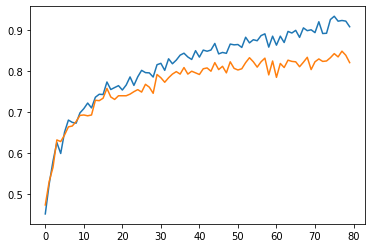

In [79]:
plt.plot(range(len(train_acc)), train_acc, range(len(val_acc)), val_acc)

In [80]:
check_accuracy(model, test_loader, 'test', device)

Got 8143 / 10000 correct (81.43) in test


0.8143

In [81]:
model, optimizer = createModel()
model.cuda() # Adam requare change model to cuda before loading it from save

checkpoint = torch.load('/content/drive/MyDrive/best_model.pt')

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

check_accuracy(model, test_loader, 'test', device)

Got 8180 / 10000 correct (81.80) in test


0.818